# Automotive industry sites

In [1]:
import pandas as pd
import numpy as np
from shapely.ops import transform

#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.offsetbox import AnchoredText

from pynsee import *

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# get activity list
naf5 = get_activity_list('NAF5')

# search data in SIRENE database
data = search_sirene(variable="activitePrincipaleEtablissement",
                     pattern='29.10Z', kind='siret', number=2000)

Existing environment variable sirene_key used, instead of locally saved credentials
2/2 - Getting data: 100%|██████████| 368/368 [00:01<00:00, 334.94it/s]
This function may return personal data, please check and comply with the legal framework relating to personal data protection !


In [ ]:
data.to_csv('sirene.csv')

In [ ]:
data.head()

In [5]:
# keep only businesses with more then 100 employees
df = data.loc[data['effectifsMinEtablissement'] > 100]
df = df.reset_index(drop=True)
# find latitude and longitude of all businesses
gdf = df.get_location().sort_values(by=['effectifsMinEtablissement'], ascending=False)

Getting location: 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


In [6]:
# get map - departement limits
geodataList =  get_geodata_list()
mapdep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement', update=True)
mapdep = mapdep.transform_overseas()
mapdep.head()

AttributeError: 'GeoFrDataFrame' object has no attribute 'code_insee_du_departement'

In [ ]:
# make cleaned labels
match_list = ['RENAULT SAS', 'ALPINE', 'BATILLY', 'MAUBEUGE CONSTRUCTION',
              'TOYOTA', 'STELLANTIS AUTO SAS', 'RENAULT TRUCKS']
other_string_list = '|'.join(['[^' + x + ']' for x in match_list])

conditions = [gdf['denominationUniteLegale'].str.contains(x) for x in match_list]
conditions += [gdf['denominationUniteLegale'].str.contains(other_string_list)]

values = ['RENAULT SAS', 'RENAULT SAS', 'RENAULT SAS', 'RENAULT SAS',
          'TOYOTA', 'STELLANTIS AUTO SAS', 'RENAULT TRUCKS', 'OTHER']

gdf['label'] = np.select(conditions, values)

KeyError: 'label'

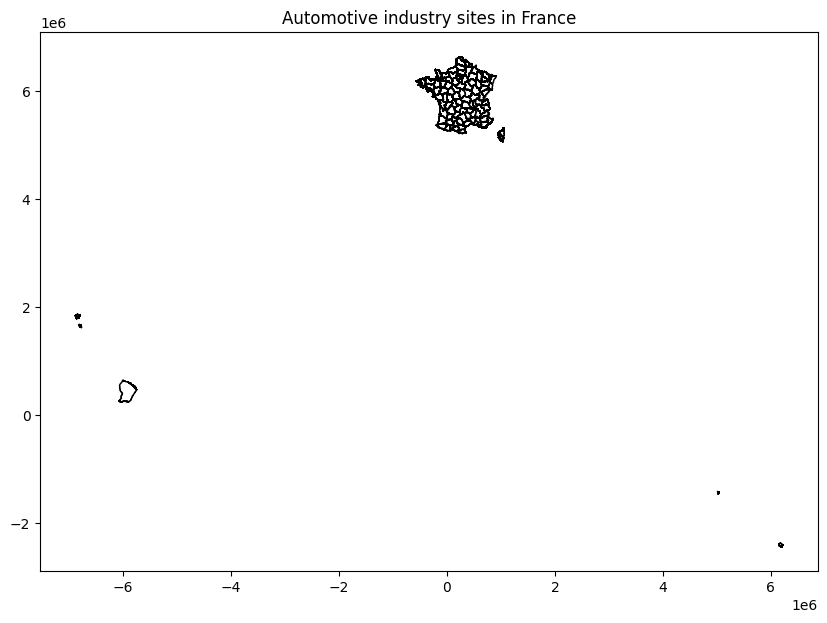

In [7]:
# change projection
gdf = gdf.to_crs('EPSG:3857')
# annotation
txt = 'Circles are proportionate to the minimum of the employee number range'
txt += '\nIf headcount is missing in SIRENE database, some factories may not be displayed'

#plot
ax = mapdep.plot(color='white', edgecolor='black', figsize = (15,7))
plt.title('Automotive industry sites in France')
gdf.plot(ax=ax,
         column = 'label',
         edgecolor='white',
         markersize=gdf.effectifsMinEtablissement/5,
         legend=True,
         legend_kwds={'bbox_to_anchor': (1.1,1),
                       'loc':1, 'borderaxespad': 0})

at = AnchoredText(txt, prop=dict(size=9), frameon=True, loc='lower left')
ax.add_artist(at)
ax.set_axis_off()
plt.show()